In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Goal

To test the predictive autoencoder model's ability to discover factors that predict stock returns, as measured by accuracy of its predictions, and compare these factors to those found by more traditional factor analysis.

## Methods
All factor-analysis methods are constrained to find only *linear* combinations of the stocks because nonlinear combinations would be impractical to buy and sell in real life.

Factor-analysis methods to compare:
- PCA
    - Linearity constraint: built in
    - Predictions generated: by regressing 1 step ahead
- Predictive autoencoder
    - Linearity constraint: linear activation functions on encoder side
    - Predictions generated: directly as output
    - Variants:
        - Trained 0 steps ahead
            - In this case the predictions are generated after retraining the decoder side alone to predict N steps ahead. This will force it to generate predictions from the existing factors found by the encoder side.
        - Trained 1 step ahead
        - Trained N steps ahead
        - Trained a variable number of steps ahead (1 to some upper bound)
        - Linear decoder side
        - Nonlinear decoder side

--------
### Data Set
The raw data consists of daily S&P500 records in the form of a single CSV file, one row per stock per day. It includes various metrics of the stock's activity that day but we're only interested in the returns.

In [2]:
# raw = pd.read_csv('./SP500DataSet/dailydata.csv', parse_dates=['date'])
raw = pd.read_csv('./SP500DataSet/monthlydata.csv', parse_dates=['date'])
raw

,PERMNO,date,TICKER,CUSIP,PRC,VOL,RET
0,10057,1990-01-31,AMT,00462610,10.25000,3873.0,-0.048276
1,10057,1990-02-28,AMT,00462610,10.12500,2495.0,-0.012195
2,10057,1990-03-30,AMT,00462610,9.62500,3004.0,-0.049383
3,10057,1990-04-30,AMT,00462610,9.12500,1178.0,-0.041558
4,10057,1990-05-31,AMT,00462610,9.00000,1719.0,-0.013699
...,...,...,...,...,...,...,...
198578,93429,2023-08-31,CBOE,12503M10,149.71001,155105.0,0.075745
198579,93429,2023-09-29,CBOE,12503M10,156.21001,134771.0,0.043417
198580,93429,2023-10-31,CBOE,12503M10,163.89000,165000.0,0.049165
198581,93429,2023-11-30,CBOE,12503M10,182.19000,191395.0,0.115016


To prepare this data for use:
- Verify that all stocks are represented for all dates.
- Reformat with one column per stock. Each row will represent the returns of all stocks on one date.

In [3]:
# Reformat first for ease of verifying stock date ranges
# Since this takes forever, cache result in file for reuse
from os import path
REFORMATTED_DATA = './SP500DataSet/reformatted.csv' # delete this file to force reprocessing of raw data

if path.isfile(REFORMATTED_DATA):
    df = pd.read_csv(REFORMATTED_DATA, parse_dates=['date'], index_col='date')
else:
    stock_id = 'PERMNO' # unique identifier for a security - may be interchangeable with PERMCO for this purpose but theoretically more likely to be unique

    # For performance, don't build dataframe on the fly
    # Instantiate a blank one with all rows/columns first and then write to its cells
    dates = set()
    stocks = set()
    for row in raw.iloc:
        dates.add(row['date'])
        stocks.add(row[stock_id])
    df = pd.DataFrame(index=pd.DatetimeIndex(data=dates, name='date'), columns=list(stocks)).sort_index()
    for row in raw.iloc:
        df.loc[row['date'], row[stock_id]] = row['RET']
        
    df.to_csv(REFORMATTED_DATA)

In [4]:
df

,34817,14338,20482,49154,65541,71685,86021,67598,59408,34833,...,47079,18411,22509,26607,18420,18421,22517,61428,81910,92157
date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,-0.153527,NaN,-0.038971,-0.062868,0.384615,-0.045455,NaN,-0.063557,-0.091892,-0.101266,...,-0.150476,-0.054592,0.000000,-0.086420,NaN,NaN,-0.046647,0.0,NaN,NaN
1990-02-28,0.078431,NaN,-0.013462,0.036981,-0.166667,0.095238,NaN,-0.017316,0.067857,0.061033,...,0.036269,-0.032407,0.015849,0.045946,NaN,NaN,0.012232,0.0,NaN,NaN
1990-03-30,0.197636,NaN,0.025341,0.119919,0.200000,0.043478,NaN,0.030837,-0.129213,-0.008850,...,-0.080000,0.004785,0.068750,0.000000,NaN,NaN,0.030091,0.0,NaN,NaN
1990-04-30,-0.026616,NaN,0.021597,-0.018149,-0.111111,0.025417,NaN,0.021453,-0.019355,-0.018265,...,-0.024130,-0.071429,0.046784,-0.012987,NaN,NaN,-0.044776,0.0,NaN,NaN
1990-05-31,0.130859,NaN,0.121723,0.123179,0.031250,0.000000,NaN,0.051502,0.028947,0.023256,...,0.034091,0.047590,0.121117,0.085526,NaN,NaN,0.059375,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.000058,-0.043025,-0.075721,-0.064630,-0.054363,NaN,NaN,-0.043518,-0.096562,-0.005386,...,NaN,-0.054050,-0.010354,-0.084465,-0.003886,-0.020057,-0.094806,NaN,NaN,-0.073246
2023-09-29,-0.088553,0.010293,-0.058795,-0.126274,-0.140490,NaN,NaN,-0.107872,-0.044995,0.036152,...,NaN,-0.044441,-0.084368,-0.107527,-0.056261,-0.053735,-0.044944,NaN,NaN,-0.066923
2023-10-31,-0.054749,0.008989,-0.018482,0.001990,-0.019685,NaN,NaN,-0.153050,-0.037984,-0.047318,...,NaN,0.039864,-0.054160,-0.109819,-0.025962,-0.033587,0.042869,NaN,NaN,-0.045981


In [5]:
# Visual inspection shows that not all stocks are represented on all dates
# Also, enforce that all values are valid numerical values (a previous attempt at PCA failed because they weren't)
# See if removing the stocks with missing dates or malformed data will leave the data set large enough to be usable
clean = df.apply(pd.to_numeric, errors="coerce").dropna(axis=1)

In [6]:
clean

,34817,20482,49154,65541,67598,59408,34833,69649,75819,16432,...,59328,32707,14277,61399,30681,88031,18411,22509,26607,22517
date,,,,,,,,,,,,,,,,,,,,,
1990-01-31,-0.153527,-0.038971,-0.062868,0.384615,-0.063557,-0.091892,-0.101266,-0.012358,-0.151515,-0.172414,...,0.144928,-0.040000,-0.038168,-0.071864,-0.082524,0.029412,-0.054592,0.000000,-0.086420,-0.046647
1990-02-28,0.078431,-0.013462,0.036981,-0.166667,-0.017316,0.067857,0.061033,0.148760,0.035714,-0.050000,...,0.018987,0.094242,0.008995,-0.041284,-0.021164,0.192857,-0.032407,0.015849,0.045946,0.012232
1990-03-30,0.197636,0.025341,0.119919,0.200000,0.030837,-0.129213,-0.008850,0.075396,0.068966,0.059259,...,0.037267,-0.072917,0.108179,0.258373,0.026811,0.772455,0.004785,0.068750,0.000000,0.030091
1990-04-30,-0.026616,0.021597,-0.018149,-0.111111,0.021453,-0.019355,-0.018265,-0.013423,-0.032258,-0.010490,...,-0.053892,-0.071161,-0.045238,0.053384,-0.015957,-0.067568,-0.071429,0.046784,-0.012987,-0.044776
1990-05-31,0.130859,0.121723,0.123179,0.031250,0.051502,0.028947,0.023256,0.118912,0.233333,0.023322,...,0.221519,0.100323,0.170574,0.369565,0.075676,0.000000,0.047590,0.121117,0.085526,0.059375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.000058,-0.075721,-0.064630,-0.054363,-0.043518,-0.096562,-0.005386,-0.049787,-0.099753,-0.197139,...,-0.014118,-0.095935,0.010627,-0.016178,-0.042661,-0.001392,-0.054050,-0.010354,-0.084465,-0.094806
2023-09-29,-0.088553,-0.058795,-0.126274,-0.140490,-0.107872,-0.044995,0.036152,-0.035759,-0.025183,-0.037180,...,0.011668,0.054264,-0.006954,-0.098230,-0.071966,-0.077687,-0.044441,-0.084368,-0.107527,-0.044944
2023-10-31,-0.054749,-0.018482,0.001990,-0.019685,-0.153050,-0.037984,-0.047318,-0.049686,0.007833,-0.042639,...,0.026723,-0.061433,-0.045283,-0.077800,0.005773,-0.034939,0.039864,-0.054160,-0.109819,0.042869


Of the 734 stocks in the data set, 255 are represented with well-formed data over the whole date range. This 255 is the same order of magnitude as the original 734. This makes it reasonable to drop all stocks but the clean 255 for the purposes of testing the autoencoder approach.

If the goal were to actually make money on the stock market, it would be more reasonable to truncate the date range to the last N years (for some fairly small N) before dropping any - this would give a data set that's more relevant to current market conditions while taking advantage of newer stocks.

## PCA
Use a rough visual approximation of the broken-stick method to find the optimal number of components:

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

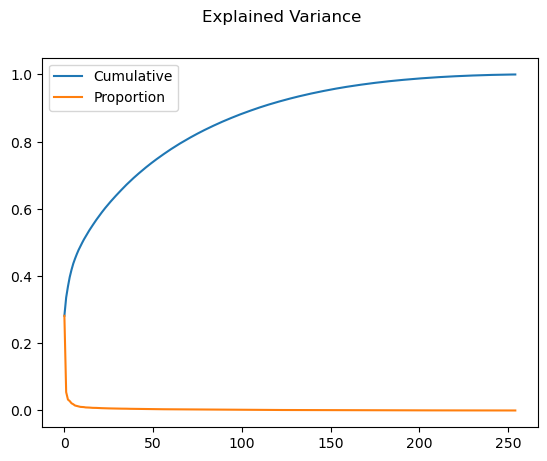

In [8]:
def pca_plot(df):
    max_components = len(df.columns)
    scaled = StandardScaler().fit_transform(df)
    explained_variances = np.zeros(max_components)
    pca = PCA()
    pca.fit(scaled)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative')
    plt.plot(pca.explained_variance_ratio_[:max_components], label='Proportion')
    plt.suptitle('Explained Variance')
    plt.legend()
    return pca.explained_variance_ratio_ # for numeric selection
eigenvalues = pca_plot(clean);

Try 50-100 factors OR numerically decide

### Selecting number of factors numerically

#### Broken stick method
Make a null distribution assuming all the factors are uncorrelated, so the variance is distributed among them at random. Retain only factors that explain more variance than the ones at the same place in the null distribution.

In [9]:
distro_size = len(eigenvalues)
sequence = np.array([1/(distro_size - i) for i in range(0, distro_size)]) # ordered smallest to largest terms
# null_distro = np.array([np.sum(sequence[:i]) / distro_size for i in range(distro_size, 0, -1)])
null_distro = (np.cumsum(sequence) / distro_size)[::-1] # reversed so that nth element is sum of all but n largest components

7 factors explain 0.45192364023642384 of the variance


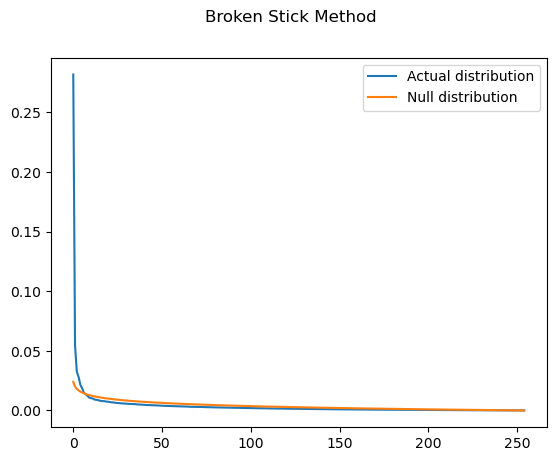

In [10]:
bs_factors = np.argmin(eigenvalues > null_distro)
# implicitly subtracting 1 to get index of last eigenvalue to make the cutoff, then adding 1 back to convert from index to count
plt.plot(eigenvalues, label='Actual distribution')
plt.plot(null_distro, label='Null distribution')
plt.suptitle('Broken Stick Method')
plt.legend()
print(f'{bs_factors} factors explain {sum(eigenvalues[:bs_factors])} of the variance')

#### Kaiser-Guttman test
Retain only principal components whose eigenvalue is greater than average. A more lenient criterion: greater than 0.7 of the average.

In [11]:
def kaiser_guttman(eigenvalues, coeff_of_average=1):
    cutoff = coeff_of_average * np.mean(eigenvalues)
    return (eigenvalues > cutoff).argmin()
    # implicitly subtracting 1 to get index of last eigenvalue to make the cutoff, then adding 1 back to convert from index to count
min_kg_factors = kaiser_guttman(eigenvalues)
max_kg_factors = kaiser_guttman(eigenvalues, 0.7)
print(f'{min_kg_factors} to {max_kg_factors} factors explain {sum(eigenvalues[:min_kg_factors])} to {sum(eigenvalues[:max_kg_factors])} of the variance')

52 to 77 factors explain 0.7443170577737416 to 0.8268437728132757 of the variance


These two methods strongly disagree, but since the broken stick number would throw out most of the variance, it's better to use one of the Kaiser-Guttman numbers instead. We'll use the lower one as a compromise.

In [28]:
n_factors = min_kg_factors
# TODO test the other 2 as well: 7 & 77

--------
## Testing Models

As a baseline, test the predictions of the PCA model regressed 1 step ahead (TODO)

Compare to the equivalent autoencoder model - trained to reproduce its input, then "regressed one step ahead" by retraining only the decoder side to reproduce the time point one step ahead of its input.

All of these tests will need a way to build a data set for the autoencoder where input is a time point and output is the time point N steps ahead of input.

TODO extend to case where N is a range of steps ahead

In [29]:
def build_autoencoder_data(df, steps_ahead):
    '''
    Return (X, y) where X and y are both ndarray.
    Elements of both X and y are rows from df with the y row coming from steps_ahead
    rows down from the X row.
    '''
    if steps_ahead < 0:
        raise ValueException(f'steps_ahead is negative: {steps_ahead}')
    out_X = []
    out_y = []
    for i in range(0, df.shape[0] - steps_ahead):
        out_X.append(df.iloc[i])
        out_y.append(df.iloc[i + steps_ahead])
    return (np.array(out_X), np.array(out_y))

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [31]:
# Train whole autoencoder to learn factors
X, y = build_autoencoder_data(clean, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5)

data_width = X.shape[1]

tf.keras.utils.set_random_seed(42)
zero_ahead_linear = Sequential()
zero_ahead_linear.add(Input(shape=(data_width,)))
zero_ahead_linear.add(Dense(name='Encoder', units=data_width))
zero_ahead_linear.add(Dense(name='Factors', units=n_factors))
zero_ahead_linear.add(Dense(name='Decoder', units=data_width))
zero_ahead_linear.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
zero_ahead_linear.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[early_stop])

Epoch 1/1000
11/11 [==============================] - 1s 23ms/step - loss: 0.0715 - val_loss: 0.0533
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0313 - val_loss: 0.0414
Epoch 3/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0208 - val_loss: 0.0330
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0152 - val_loss: 0.0261
Epoch 5/1000
11/11 [==============================] - 0s 11ms/step - loss: 0.0126 - val_loss: 0.0227
Epoch 6/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0199
Epoch 7/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.0188
Epoch 8/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0095 - val_loss: 0.0180
Epoch 9/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0172
Epoch 10/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.01

Epoch 1/1000
11/11 [==============================] - 0s 25ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 2/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 3/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 4/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 5/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 6/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 7/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 8/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 9/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 10/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0046 - val_loss: 0.005

<Axes: xlabel='StepsAhead'>

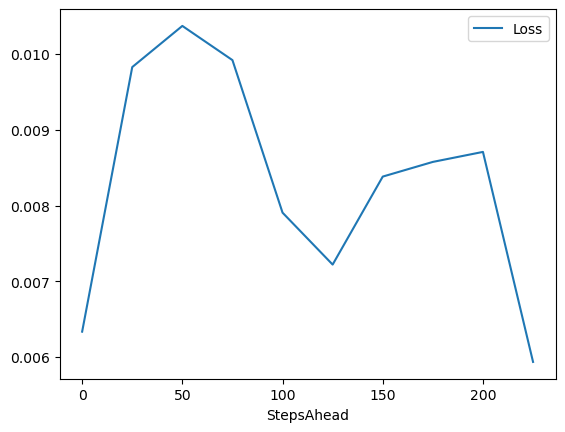

In [32]:
# Retrain decoder layer to predict N data points ahead based on factors already learned
# Keep track of losses as a function of steps ahead
zero_ahead_linear.get_layer('Factors').trainable = False # only retrain decoder layer
losses = []
tf.keras.utils.set_random_seed(42)
# for steps_ahead in [0, 1, 2, 4, 8, 16, 32, 64, 128, 256]: # start at 0 for convenience on repeated runs
for steps_ahead in range(0, 250, 25):
    X, y = build_autoencoder_data(clean, steps_ahead)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5)
    zero_ahead_linear.get_layer('Encoder').trainable = False # only retrain decoder layer
    zero_ahead_linear.get_layer('Factors').trainable = False # only retrain decoder layer
    zero_ahead_linear.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[early_stop])
    losses.append({'StepsAhead': steps_ahead, 'Loss': zero_ahead_linear.evaluate(x=X_test, y=y_test)})
    
pd.DataFrame(losses).set_index('StepsAhead').plot()

This implies no information about the future gained from PCA on the present time step. The factors do predict returns better than chance (compare to losses from early steps of training) but whatever information goes into this prediction appears to be time-invariant. So this model is not capturing any information about how returns evolve over time.

In [ ]:
# TODO  make analogous graph with PCA regressed N steps ahead - loss vs. N?

In [ ]:
# TODO repeat with leaky ReLU decoder

## Find Out / TODO
- Nonlinear: ReLU? Should be able to approximate any function w/enough layers but see if there's a reason to expect other activation functions to be more efficient
    - *or leaky ReLU? (doesn't saturate on left side)*
- When comparing networks TRAINED N steps ahead, confirm that we try to PREDICT the same # because N will be the same for train & test splits? *yes*
- For variable # steps ahead:
    - How many steps ahead is prediction? If doing inference on test split, will be unpredictable, but will there be a way to use it to control how many? Or is unpredictability not a problem for the intended use?
    - If the same input sequence maps to 2 different output sequences because those data points have 2 different N's, is this a problem? Will hinder accuracy if happens in test set but will it hinder learning if happens in training set?
    - *answer: we're not mapping input -> equal length output sequence, we're mapping input -> N equal-length output sequences where ith is i steps ahead*
- Verify input & output sequences consist of ONE time point EXACTLY N steps ahead? (except variable-length sequence where output is N of them)
  - **Anything to be gained from using multiple time points as input? Takes advantage of what can be learned from their order** *for later - RNN/transformer? but for now try adding small # steps before t to input -> proximity is sequence information*
- How to avoid survivorship bias?
    - 0 for NaNs? (but edge case on day when company goes bust -> 100% negative returns?) *<- code the 100% neg. return case explicitly; 0 returns thereafter*
- When switching to daily, truncate to 2015-present
- Is Kaiser-Guttman the way to go because of its real-world interpretation? A real stock portfolio's goal is to beat the index funds, S&P500 is an index fund, so intuition says that the average eigenvalue in it should be a meaningful cutoff *who cares, OK to test # factors from all criteria*
- How to regress PCA one step ahead? *linear regression where x = factors calculated from today's stock returns & y = tomorrow's actual returns*
- How many steps ahead max? Loss vs. steps graph inconclusive. *Domain knowledge suggests max. 6 because of the trading week.*

#### Citations

1. Idea and ongoing guidance provided by Cameron Fen
1. Brygalova, DeMiguel, Li, Pelger (2023) "Asset-Pricing Factors with Economic Targets"
1. WRDS data set: https://wrds-www.wharton.upenn.edu/
1. Numerical methods for selecting principle components: https://blogs.sas.com/content/iml/2017/08/02/retain-principal-components.html